In [ ]:
!pip install fastai

# Binary Segmentation

As it was asked for, here is an example of binary segmentation. We will be using a selfie dataset that originates from [here](https://github.com/clovaai/ext_portrait_segmentation)

In [ ]:
file = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [ ]:
!gdown {file}

Downloading...
From: https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z
To: /content/Portrait.zip
107MB [00:02, 44.4MB/s]


We'll unzip the data

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('Portrait.zip', 'r') as zip_ref:
  zip_ref.extractall('')

In [ ]:
from fastai.vision.all import *

And grab our ground truth labels and files

In [ ]:
path = Path('')

In [ ]:
lbl_names = get_image_files(path/'GT_png')
fnames = get_image_files(path/'images_data_crop')

In [ ]:
img_fn = fnames[10]; img_fn

Path('images_data_crop/00970.jpg')

In [ ]:
lbl_names[10]

Path('GT_png/02621_mask.png')

In [ ]:
fn = '00013.jpg'

In [ ]:
im = PILImage.create(f'images_data_crop/{fn}')

In [ ]:
msk = PILMask.create(f'GT_png/00013_mask.png')

Now, our mask isn't set up how `fastai` expects, in which the mask points are **not** all in a row. We need to change this:

In [ ]:
len(np.unique(msk))

2

In [ ]:
np.unique(msk)

array([  0, 255], dtype=uint8)

We'll do this through an `n_codes` function. What this will do is run through our masks and build a set based on the unique values present in our masks. From there we will build a dictionary that will replace our points once we load in the image

In [ ]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [ ]:
vals = n_codes(lbl_names)

So `vals` in this case is anywhere that is 255 in our mask should be replaced to one

In [ ]:
vals

{0: 0, 1: 255}

So now let's build a `get_msk` function that will modify our mask we get based on this dictionary and override those values

In [ ]:
def get_msk(fn, pix2class):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path/'GT_png'/f'{fn.stem}_mask.png'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [ ]:
codes = ['Background', 'Face']

Now we can build a `get_y` and a `DataBlock`!

In [ ]:
get_y = lambda o: get_msk(o, p2c)

In [ ]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = binary.dataloaders(path/'images_data_crop', bs=8)

We can look at how our masks look by adjusting the colormap and the vmin and max

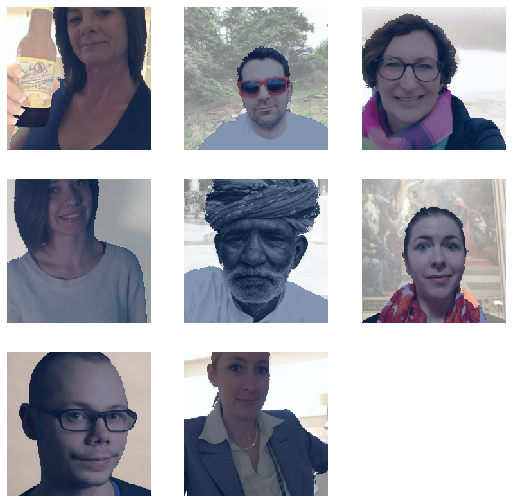

In [ ]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

And now we can train!

In [ ]:
learn = unet_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.287433,0.168146,00:43


And we're good :)

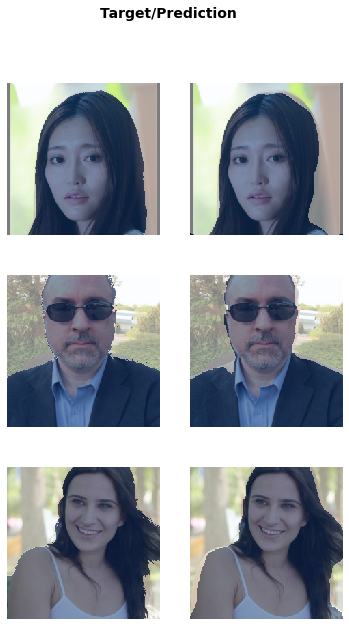

In [ ]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

If we want to examine it further we can do:

In [ ]:
preds = learn.get_preds()

In [ ]:
preds[0][0].shape

torch.Size([2, 224, 224])

In [ ]:
p = preds[0][0]

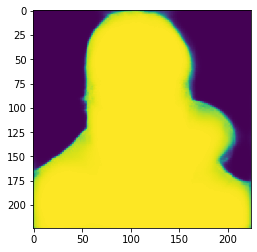

In [ ]:
plt.imshow(p[1])

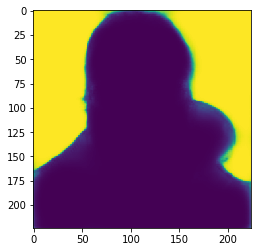

In [ ]:
plt.imshow(p[0])